In [99]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from sklearn.preprocessing import LabelEncoder

import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import seaborn as sns
import json
import requests
import csv
import urllib.request
%matplotlib inline
import librosa
import numpy as np
import os
import librosa.display
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow_io as tfio
import tensorflow as tf
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from scipy.ndimage import zoom # ensures that audios have same shape


In [100]:
from pydub import AudioSegment

# define paths to files

In [101]:
alarm_call = os.path.join("bird_sounds", "alarm_calls", "2679.mp3")
mating_call = os.path.join("bird_sounds", "duet_calls", "10009.mp3")
other_call = os.path.join("bird_sounds", "other_calls", "10011.mp3")
alarm_call

'bird_sounds\\alarm_calls\\2679.mp3'

# data loading function

In [102]:
def load_audio(audio_folder, target_sr=22050):
    audio_data = []
    for filename in os.listdir(audio_folder):
        file_path = os.path.join(audio_folder, filename)
        if file_path.endswith('.mp3'):  # MP3 files can be directly loaded by librosa
            y, sr = librosa.load(file_path, sr=target_sr)
            audio_data.append(y)
    return audio_data, target_sr

def generate_spectrogram(audio_data, target_sr=22050, fixed_shape=(128, 128)):
    spectrograms = []
    for audio in audio_data:
        # Compute the spectrogram directly from the audio data
        spectrogram = librosa.feature.melspectrogram(y=audio, sr=target_sr)
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

        # Resize the spectrogram to the fixed shape
        resized_spectrogram = zoom(spectrogram_db, (fixed_shape[0] / spectrogram_db.shape[0], fixed_shape[1] / spectrogram_db.shape[1]))

        spectrograms.append(resized_spectrogram)

    return spectrograms


def visualize_spectrogram(spectrogram):
    librosa.display.specshow(spectrogram, y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

- loading file paths

In [103]:
target_sr = 22050
bird_alarm_calls, sr = load_audio('bird_sounds/alarm_calls', target_sr)
bird_duet_calls, _ = load_audio('bird_sounds/duet_calls', target_sr)
other_bird_calls, _ = load_audio('bird_sounds/other_calls', target_sr)

# Assuming all audio files have the same sampling rate
# sr = librosa.get_samplerate('path/to/any_audio_file_in_the_dataset')

bird_alarm_spectrograms = generate_spectrogram(bird_alarm_calls)
bird_duet_spectrograms = generate_spectrogram(bird_duet_calls)
other_bird_spectrograms = generate_spectrogram(other_bird_calls)


- Visualizing spectrograms

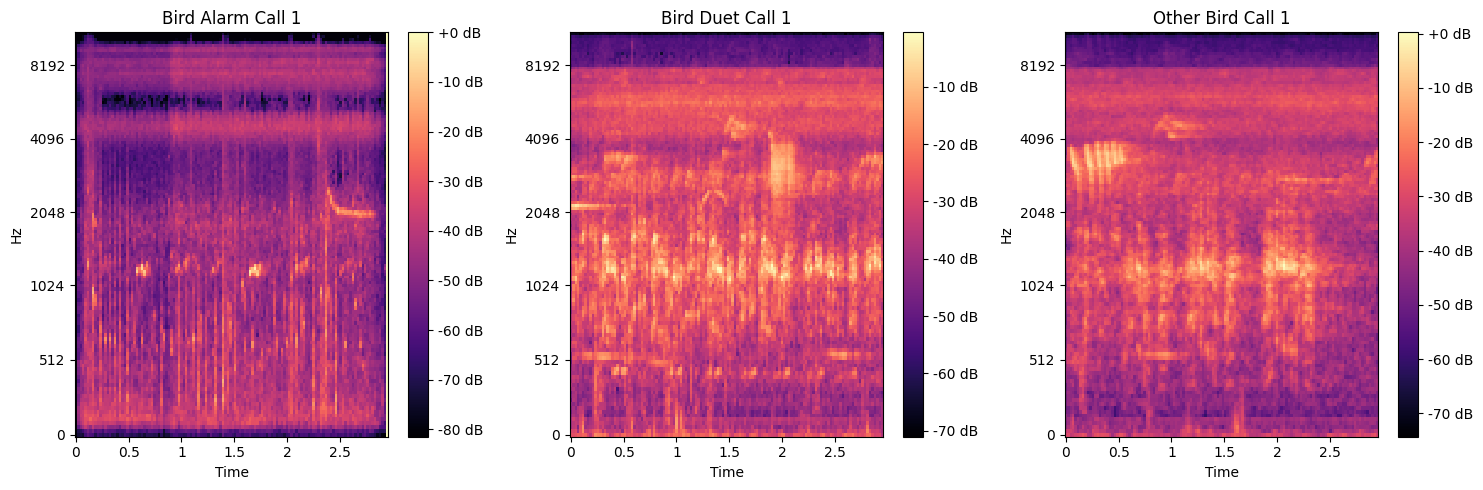

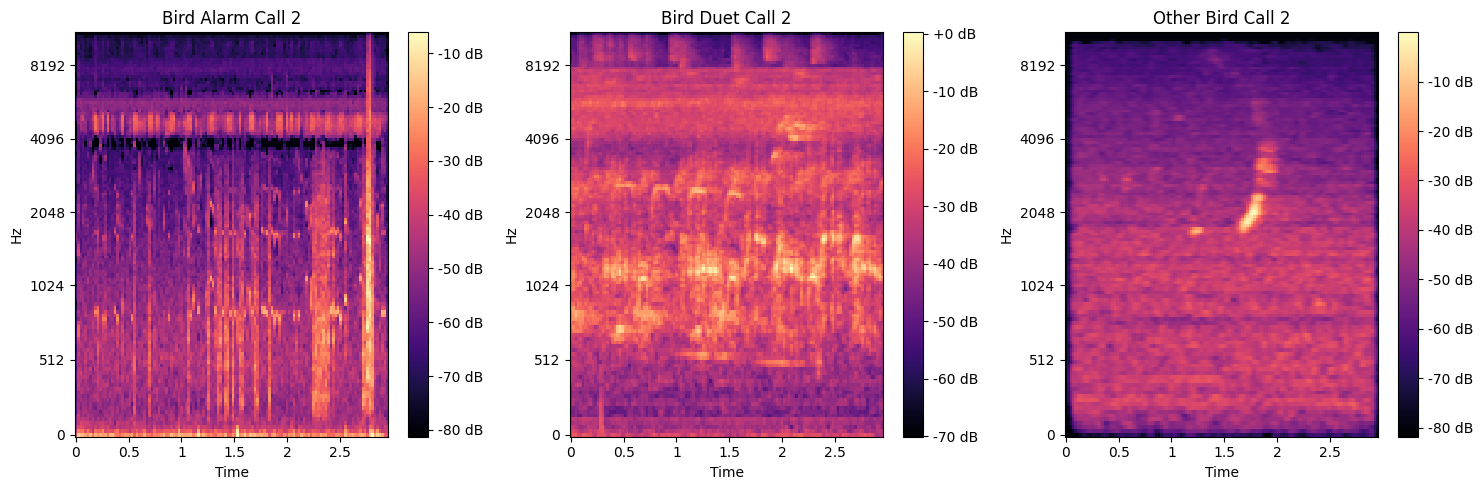

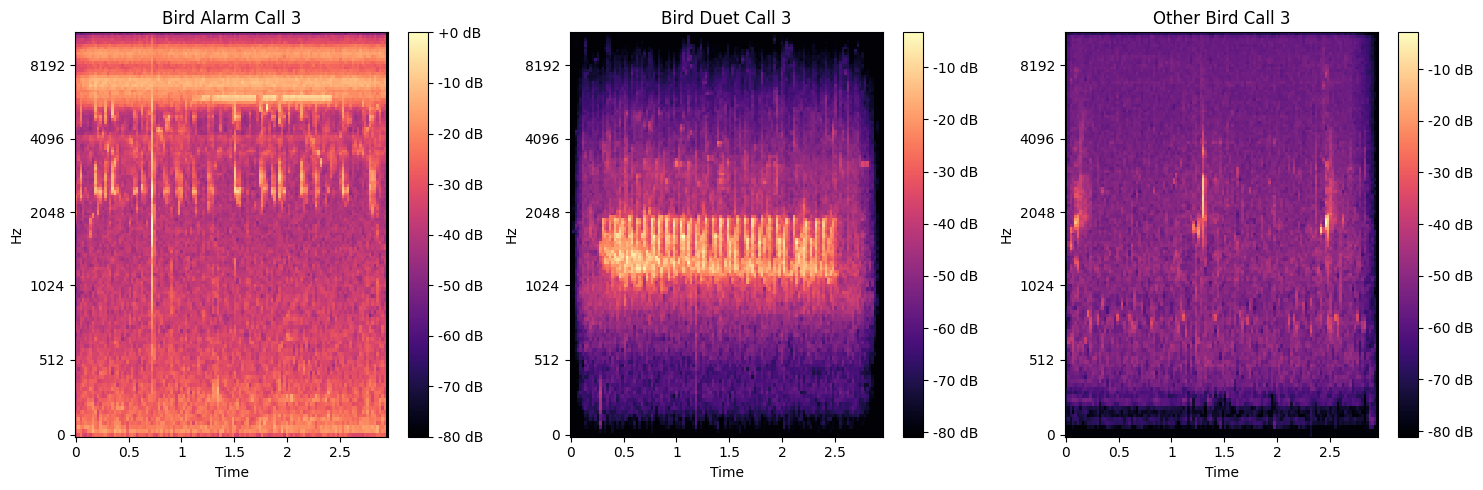

In [104]:
def visualize_multiple_spectrograms_oneline(spectrograms, titles):
    num_spectrograms = len(spectrograms)
    plt.figure(figsize=(15, 5))
    for i in range(num_spectrograms):
        plt.subplot(1, num_spectrograms, i+1)
        librosa.display.specshow(spectrograms[i], y_axis='mel', x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title(titles[i])
    plt.tight_layout()
    plt.show()

# Assuming you have already loaded and processed the audio data into the variables:
# bird_alarm_spectrograms, bird_duet_spectrograms, other_bird_spectrograms

num_samples_to_visualize = 3

for i in range(num_samples_to_visualize):
    # Get spectrograms and titles from the three categories
    alarm_spec = bird_alarm_spectrograms[i]
    duet_spec = bird_duet_spectrograms[i]
    other_spec = other_bird_spectrograms[i]
    
    # Concatenate spectrograms from the same folder side by side
    all_specs = [alarm_spec, duet_spec, other_spec]
    titles = [f"Bird Alarm Call {i+1}", f"Bird Duet Call {i+1}", f"Other Bird Call {i+1}"]
    
    # Visualize the concatenated spectrograms side by side on the same line
    visualize_multiple_spectrograms_oneline(all_specs, titles)


# Data Augmentation

In [105]:
def augment_spectrograms(spectrograms):
    augmented_spectrograms = []
    
    # Data augmentation using ImageDataGenerator
    data_generator = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    for spec in spectrograms:
        # Reshape the spectrogram into 3D array (height, width, channels=1)
        spec_3d = spec.reshape(spec.shape[0], spec.shape[1], 1)

        # Generate augmented versions of the spectrogram
        augmented_specs = data_generator.flow(np.expand_dims(spec_3d, axis=0), batch_size=1, shuffle=False)

        # Append the augmented versions to the list
        augmented_spectrograms.extend(augmented_specs[0].reshape(-1, spec.shape[0], spec.shape[1]))

    return augmented_spectrograms


Visualizing Original Spectrograms:


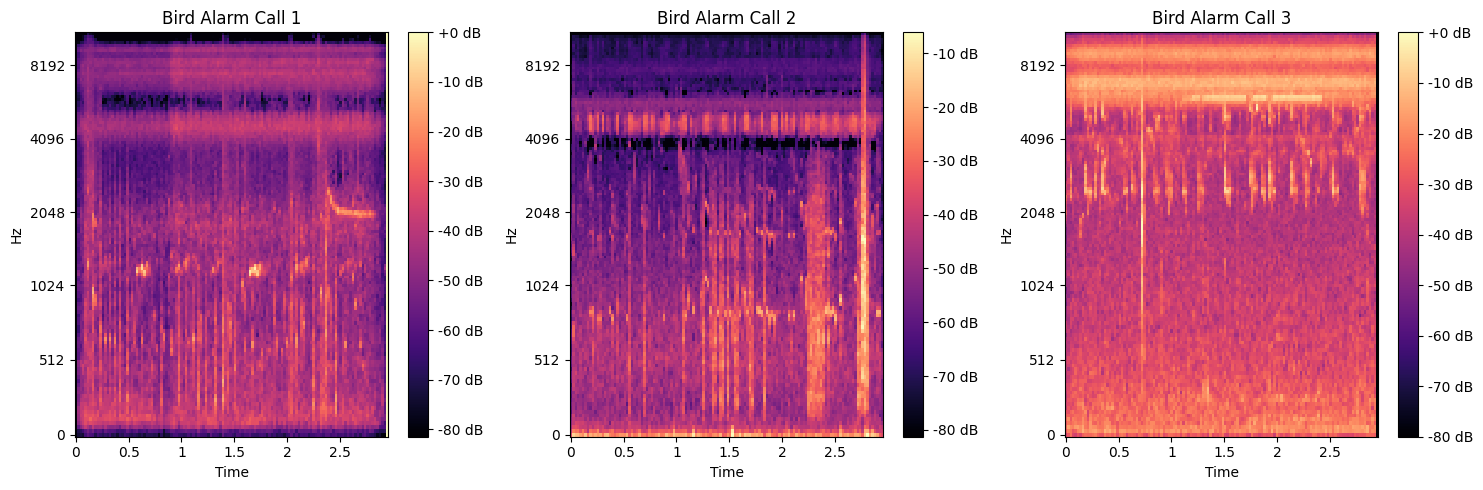

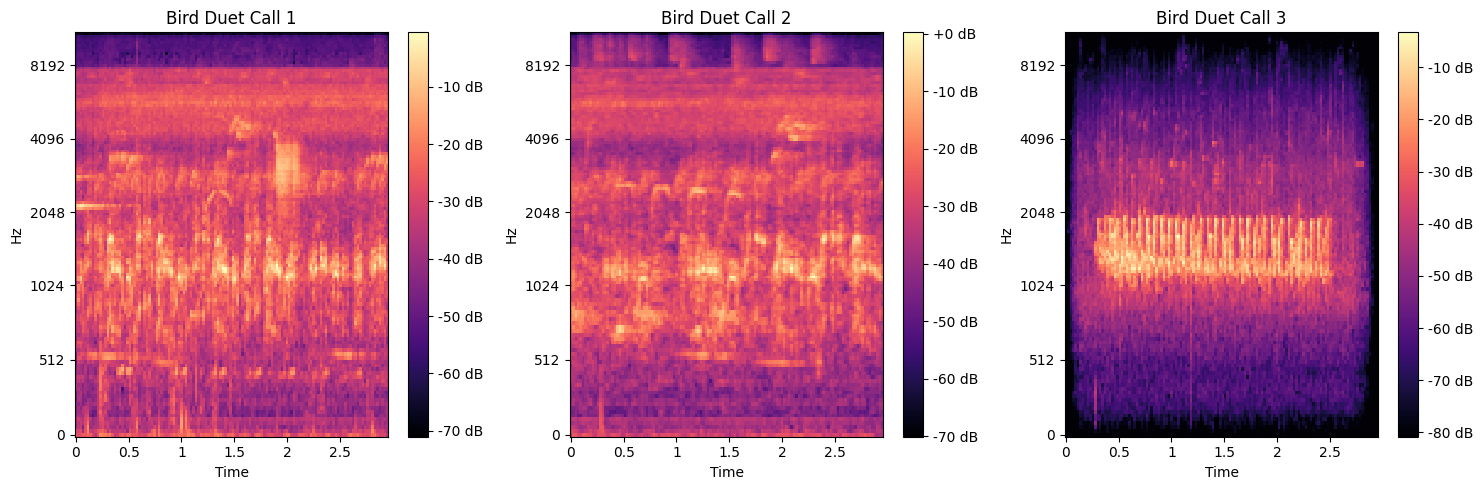

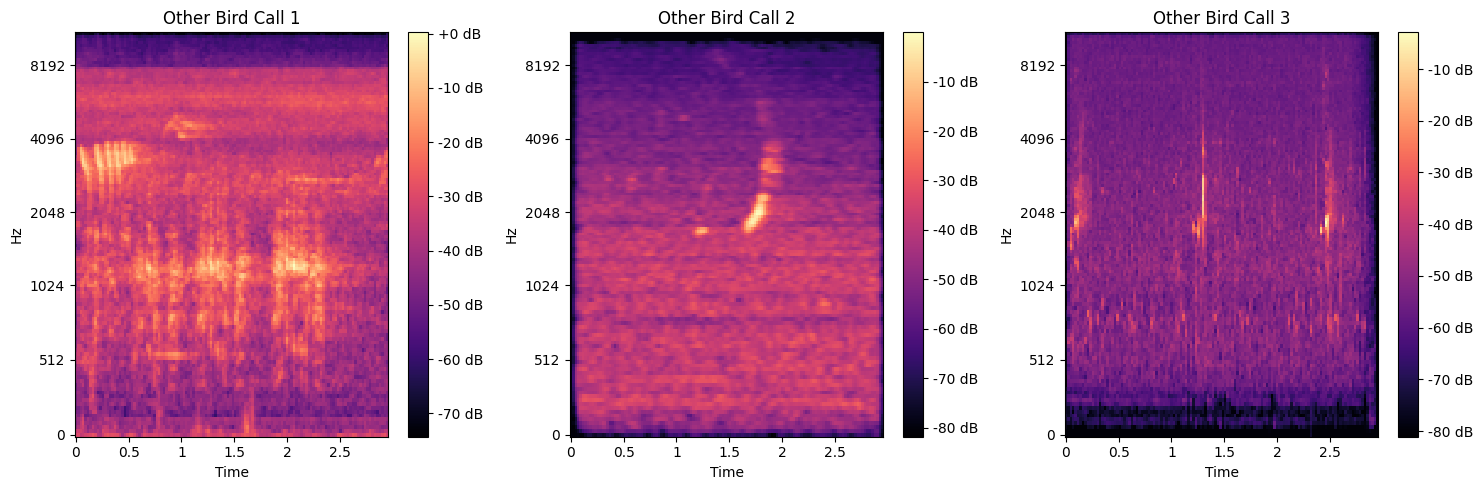

Visualizing Augmented Spectrograms:


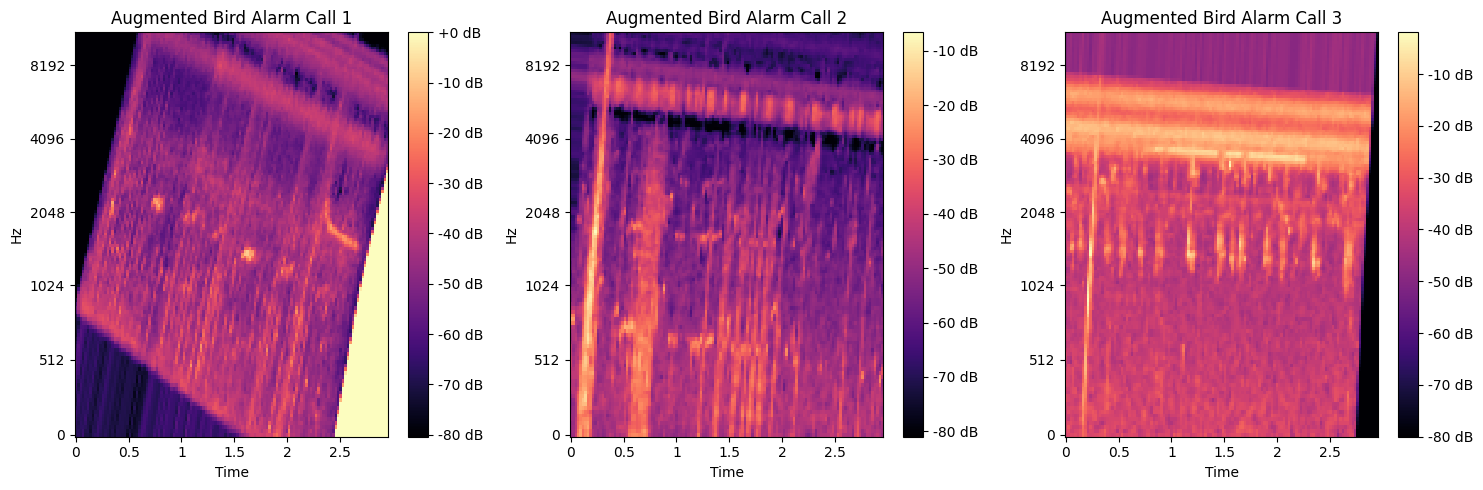

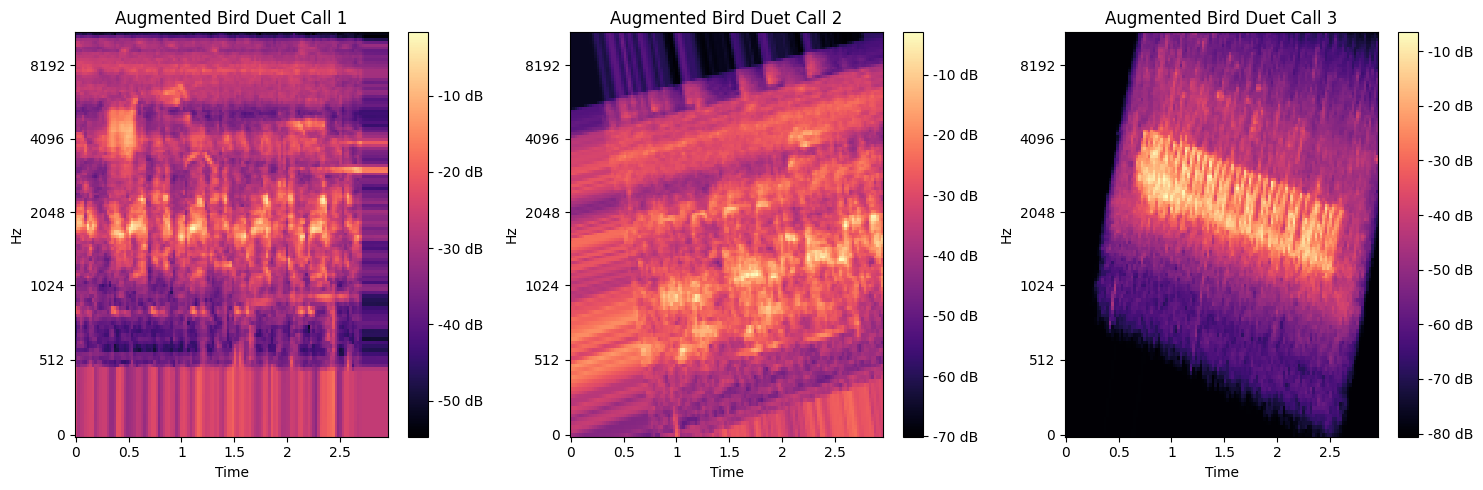

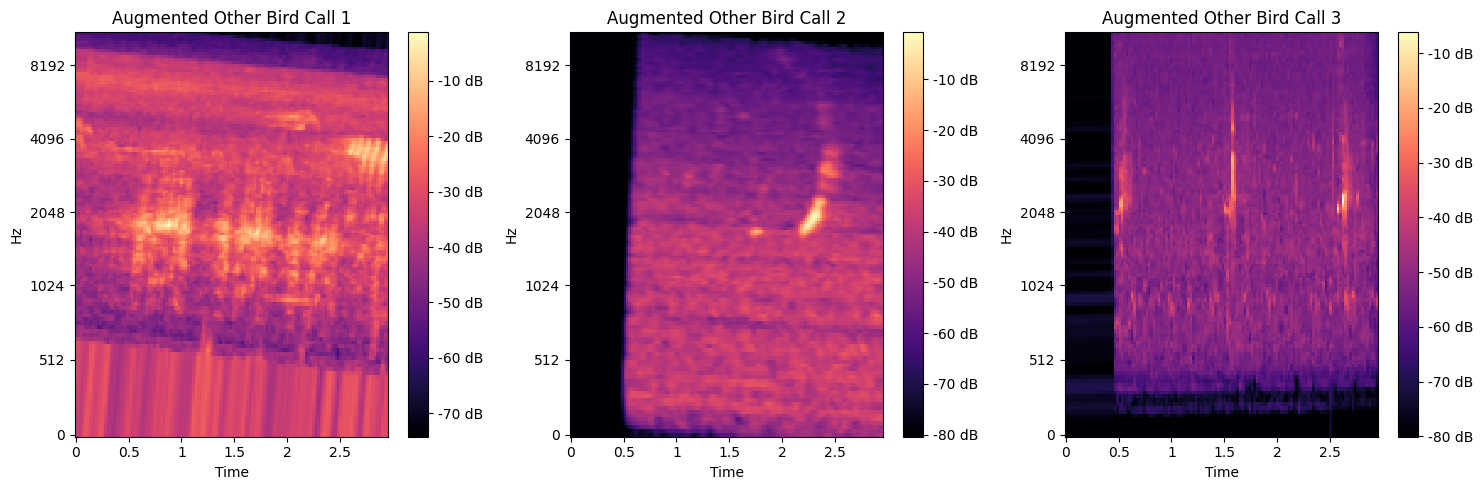

In [106]:
# Assuming you have already loaded and processed the audio data into the variables:
# bird_alarm_spectrograms, bird_duet_spectrograms, other_bird_spectrograms

# Generate augmented spectrograms for visualization
bird_alarm_augmented = augment_spectrograms(bird_alarm_spectrograms)
bird_duet_augmented = augment_spectrograms(bird_duet_spectrograms)
other_bird_augmented = augment_spectrograms(other_bird_spectrograms)

# Visualize original and augmented spectrograms separately
print("Visualizing Original Spectrograms:")
visualize_multiple_spectrograms_oneline(bird_alarm_spectrograms[:num_samples_to_visualize],
                                        ["Bird Alarm Call " + str(i + 1) for i in range(num_samples_to_visualize)])
visualize_multiple_spectrograms_oneline(bird_duet_spectrograms[:num_samples_to_visualize],
                                        ["Bird Duet Call " + str(i + 1) for i in range(num_samples_to_visualize)])
visualize_multiple_spectrograms_oneline(other_bird_spectrograms[:num_samples_to_visualize],
                                        ["Other Bird Call " + str(i + 1) for i in range(num_samples_to_visualize)])

print("Visualizing Augmented Spectrograms:")
visualize_multiple_spectrograms_oneline(bird_alarm_augmented[:num_samples_to_visualize],
                                        ["Augmented Bird Alarm Call " + str(i + 1) for i in range(num_samples_to_visualize)])
visualize_multiple_spectrograms_oneline(bird_duet_augmented[:num_samples_to_visualize],
                                        ["Augmented Bird Duet Call " + str(i + 1) for i in range(num_samples_to_visualize)])
visualize_multiple_spectrograms_oneline(other_bird_augmented[:num_samples_to_visualize],
                                        ["Augmented Other Bird Call " + str(i + 1) for i in range(num_samples_to_visualize)])




# Resizing spectrograms, Combining Labels
# Creating train and test datasets

In [107]:
# Define a fixed shape for the spectrograms
fixed_shape = (128, 128)  # Change this to the desired fixed shape

# Function to resize the spectrograms to a fixed shape
def resize_spectrograms(spectrograms, fixed_shape):
    resized_spectrograms = []
    for spec in spectrograms:
        resized_spec = zoom(spec, (fixed_shape[0] / spec.shape[0], fixed_shape[1] / spec.shape[1]))
        resized_spectrograms.append(resized_spec)
    return resized_spectrograms

# Resize original and augmented spectrograms to the fixed shape
bird_alarm_spectrograms_resized = resize_spectrograms(bird_alarm_spectrograms + bird_alarm_augmented, fixed_shape)
bird_duet_spectrograms_resized = resize_spectrograms(bird_duet_spectrograms + bird_duet_augmented, fixed_shape)
other_bird_spectrograms_resized = resize_spectrograms(other_bird_spectrograms, fixed_shape)

# Combine all data and labels
all_spectrograms = bird_alarm_spectrograms_resized + bird_duet_spectrograms_resized + other_bird_spectrograms_resized
all_labels = ['bird_alarm_calls'] * len(bird_alarm_spectrograms_resized) + ['bird_duet_calls'] * len(bird_duet_spectrograms_resized) + ['other_bird_calls'] * len(other_bird_spectrograms_resized)

# Convert labels to numeric codes
label_encoder = LabelEncoder()
label_codes = label_encoder.fit_transform(all_labels)

# One-hot encode labels
onehot_encoder = OneHotEncoder(sparse_output=False)
y = onehot_encoder.fit_transform(label_codes.reshape(-1, 1))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_spectrograms, y, test_size=0.2, random_state=42)

# Building Model

In [108]:

# Convert to 3D arrays
X_train = np.array(X_train).reshape(-1, bird_alarm_spectrograms_resized[0].shape[0], bird_alarm_spectrograms_resized[0].shape[1], 1)
X_test = np.array(X_test).reshape(-1, bird_alarm_spectrograms_resized[0].shape[0], bird_alarm_spectrograms_resized[0].shape[1], 1)

# Define the input shape based on the fixed shape
input_shape = (bird_alarm_spectrograms_resized[0].shape[0], bird_alarm_spectrograms_resized[0].shape[1], 1)

# Build the CNN model
def create_cnn_model(input_shape):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Output layer with number of classes

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = create_cnn_model(input_shape)
cnn_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_54 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_55 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_55 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_56 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_56 (MaxPooli  (None, 14, 14, 128)     

# Training Model

In [109]:
# Train the model
epochs = 25
batch_size = 32
history = cnn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.3)

Epoch 1/25
3/3 [==============================] - 10s 2s/step - loss: 70.5855 - accuracy: 0.4421 - val_loss: 38.0537 - val_accuracy: 0.5366
Epoch 2/25
3/3 [==============================] - 5s 2s/step - loss: 18.5482 - accuracy: 0.4105 - val_loss: 6.3511 - val_accuracy: 0.3415
Epoch 3/25
3/3 [==============================] - 6s 2s/step - loss: 3.7565 - accuracy: 0.3368 - val_loss: 1.8270 - val_accuracy: 0.5366
Epoch 4/25
3/3 [==============================] - 8s 3s/step - loss: 1.4324 - accuracy: 0.4737 - val_loss: 1.1912 - val_accuracy: 0.3415
Epoch 5/25
3/3 [==============================] - 6s 2s/step - loss: 1.1010 - accuracy: 0.4211 - val_loss: 0.9859 - val_accuracy: 0.5366
Epoch 6/25
3/3 [==============================] - 5s 2s/step - loss: 1.0747 - accuracy: 0.4421 - val_loss: 2.8569 - val_accuracy: 0.3415
Epoch 7/25
3/3 [==============================] - 5s 2s/step - loss: 1.6491 - accuracy: 0.4211 - val_loss: 1.0735 - val_accuracy: 0.3415
Epoch 8/25
3/3 [=====================

# Evaluate model

In [110]:
loss, accuracy = cnn_model.evaluate(X_test, y_test, batch_size=batch_size)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

2/2 [==============================] - 1s 58ms/step - loss: 1.1223 - accuracy: 0.5294
Test Loss: 1.1223, Test Accuracy: 0.5294


# Saving Model

In [113]:
cnn_model.save('bird_call_classifier_model.keras')

# Confusion Matrix

In [114]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model
y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute classification report
report = classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_)
print("Classification Report:\n", report)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)


2/2 [==============================] - 0s 27ms/step
Classification Report:
                   precision    recall  f1-score   support

bird_alarm_calls       0.67      0.50      0.57        16
 bird_duet_calls       0.22      0.40      0.29         5
other_bird_calls       0.62      0.62      0.62        13

        accuracy                           0.53        34
       macro avg       0.50      0.51      0.49        34
    weighted avg       0.58      0.53      0.55        34

Confusion Matrix:
 [[8 4 4]
 [2 2 1]
 [2 3 8]]
